# Eco Numbers

We can specify break conditions on our eco sends which, when met, force the simulator to stop eco'ing the current send and attempt to move on to the next send in the eco queue. In this tutorial document we utilize one such condition called `max_eco_amount` to determine optimal eco'ing during round 1 defense. We'll cover three base cases from which the end user can develop further to optimize their strategies:

1. Standard tack start with Jericho
2. Perfect anti-stall tack start with Jericho
3. Standard dartling start with Jericho

Let's begin by importing the b2 module.

In [1]:
import b2sim as b2

## Overview of the Eco Number Functionality

When adding sends to the eco queue in the simulator, you can specify either a maximum eco amount `max_eco_amount` or a maximum send amount `max_send_amount`. 
1. If a value for `max_eco_amount` is specified, the simulator will attempt to switch to the next send in the eco queue (or the zero send if the queue is empty) once the max eco amount has been reached or exceeded.
2. If a value for `max_send_amount` is specified, the simulator will attempt to switch to the next send in the eco queue (or the zero send if the queue is empty) once the specified bloon send has been sent the specified number of times.

## Standard Tack Start With Jericho

In the standard start, we get access to *5* eco ticks before round 2 starts, with those eco ticks occuring at times $6,12,18,24, 30$ respectively. The rule for a standard Jericho start is to eco to 273 with reds and *then* eco to 278 with blues before saving and buying Jericho.

,Time,Type,Message
0,0.0,Round,Round 0 start
1,0.0,Eco,Change eco to Zero
2,6.0,Round,Round 1 start
3,6.0,Buy,Buy Tack
4,6.0,Eco,Change eco to Grouped Reds
5,12.0,Buy,Upgrade Tack
6,19.7,Eco,Change eco to Spaced Blues
7,26.1,Eco,Change eco to Zero
8,30.0,Buy,Buy Jericho
9,32.3,Round,Round 2 start


The current cash and eco are (18.600000000000136,278.6000000000001)


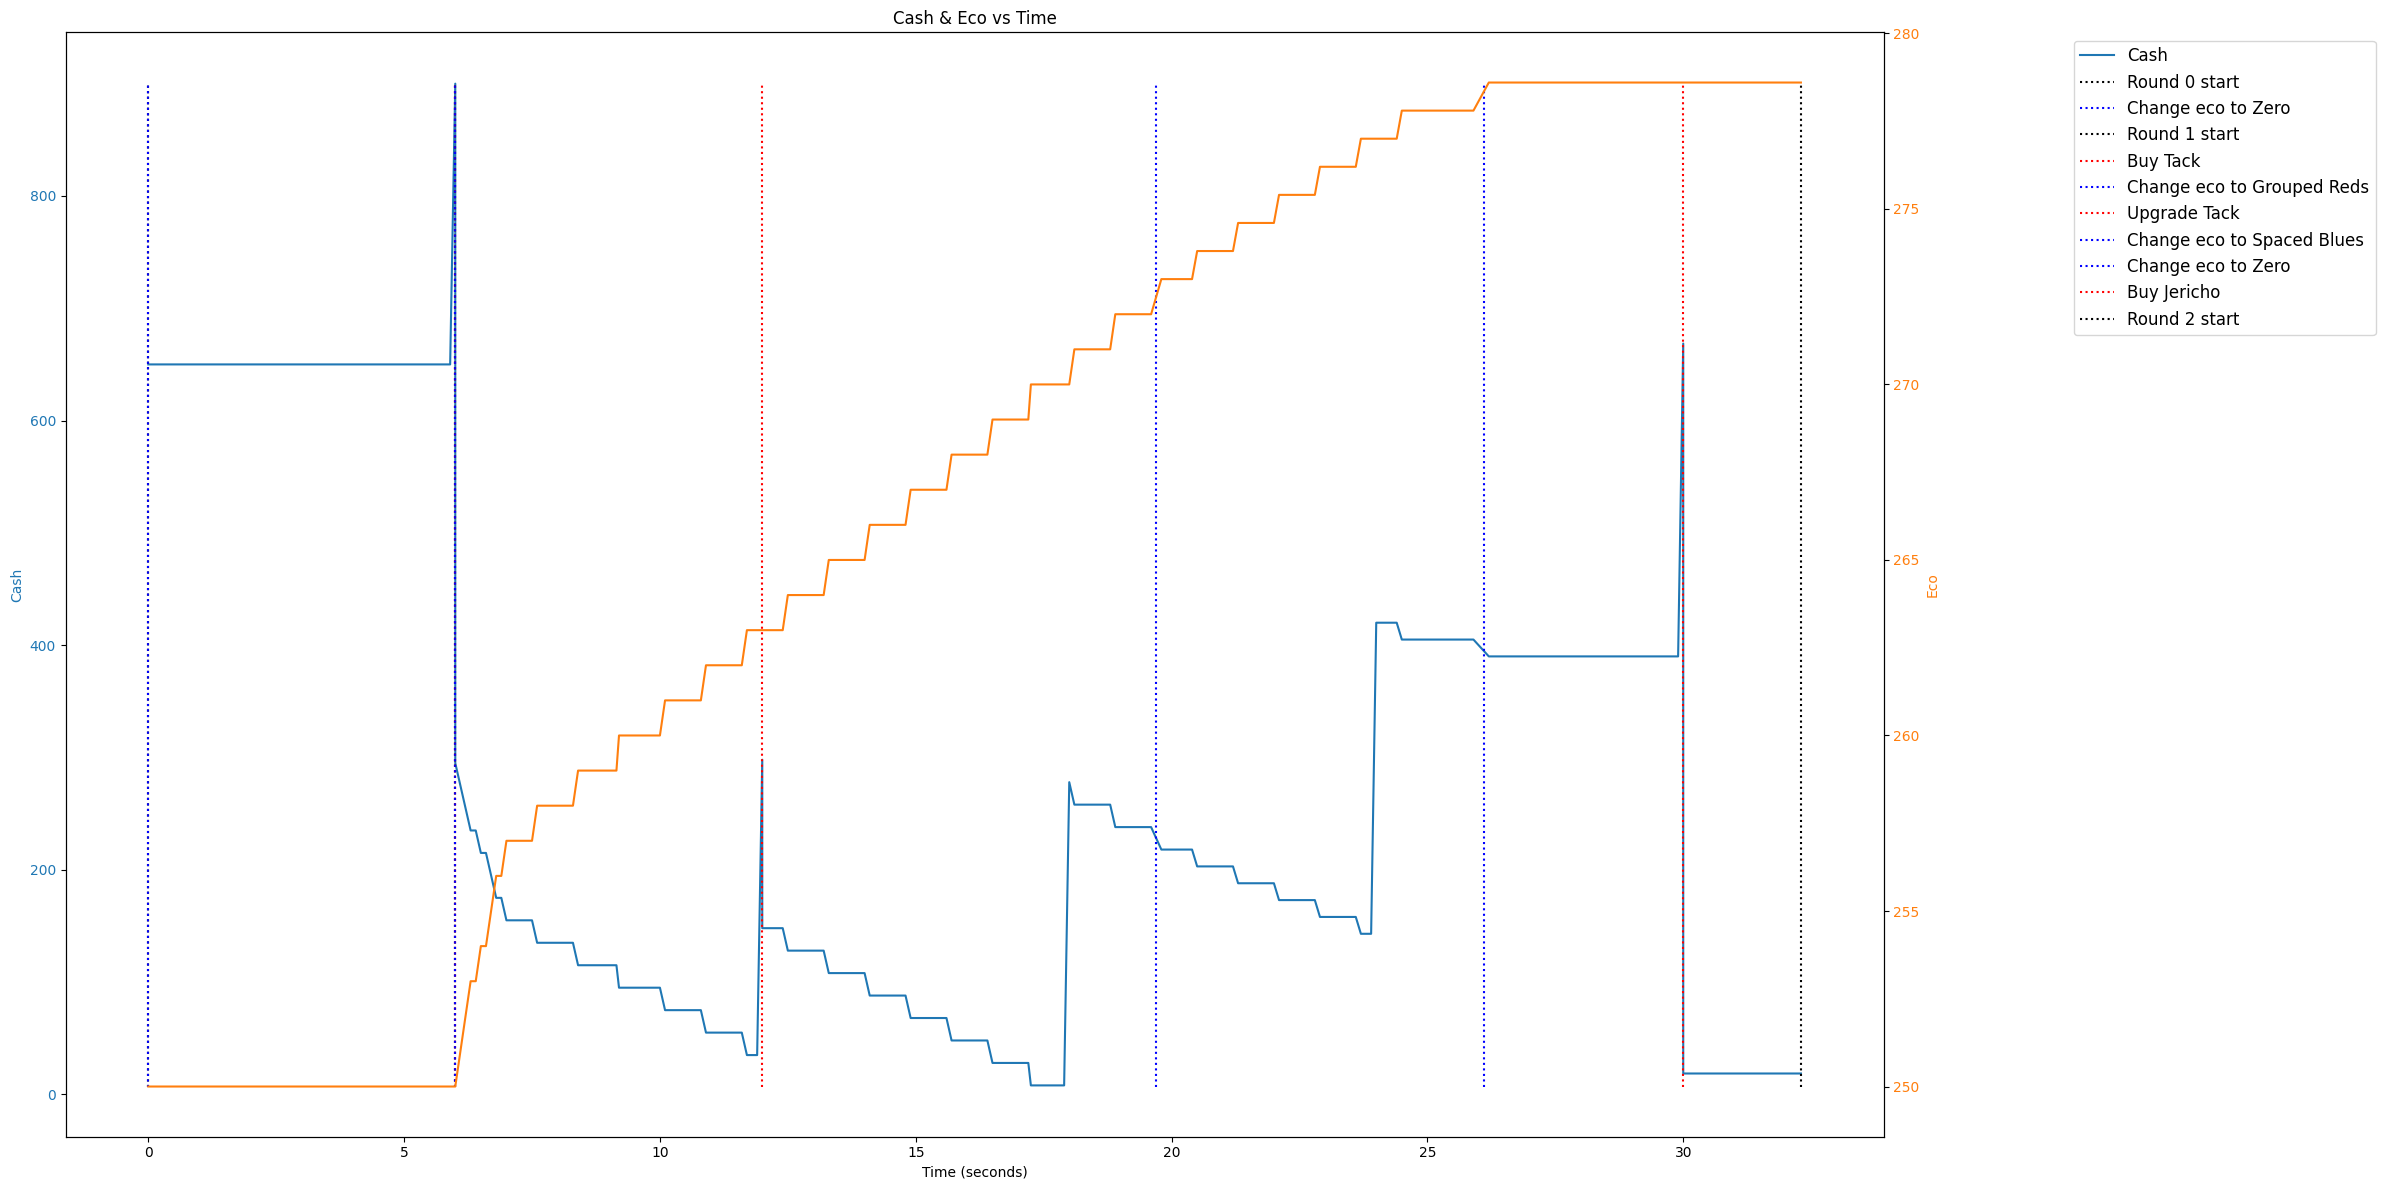

In [2]:
rounds = b2.Rounds(0.45)

buy_queue = [
    [b2.buyDefense(280 + 100 + 225, min_buy_time = rounds.getTimeFromRound(1), message = "Buy Tack")], #Buy 020 tack
    [b2.buyDefense(150, min_buy_time = rounds.getTimeFromRound(1) + 6, message = "Upgrade Tack")], #Upgrade to 120 tack
    [b2.buyDefense(650, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_queue = [
        b2.ecoSend(time = rounds.getTimeFromRound(1), send_name = 'Grouped Reds', max_eco_amount = 273),
        b2.ecoSend(send_name = 'Spaced Blues', max_eco_amount = 278)
]

initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 0,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 2)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'eco_numbers_1')

## Perfect Anti-Stall Tack Start with Jericho

If the game is perfectly anti-stalled, we will have access to one less eco tick than usual, meaning we have to adjust our strategy to get Jericho on R1. To compensate, we will not crosspath the tack and we will eco blues sooner before deciding to save for Jericho:

,Time,Type,Message
0,0.0,Round,Round 0 start
1,0.0,Eco,Change eco to Zero
2,6.0,Round,Round 1 start
3,6.0,Buy,Buy Tack
4,6.0,Eco,Change eco to Grouped Reds
5,14.9,Eco,Change eco to Spaced Blues
6,21.3,Eco,Change eco to Zero
7,24.0,Buy,Buy Jericho
8,30.5,Round,Round 2 start


The current cash and eco are (277.6000000000002,272.6000000000001)


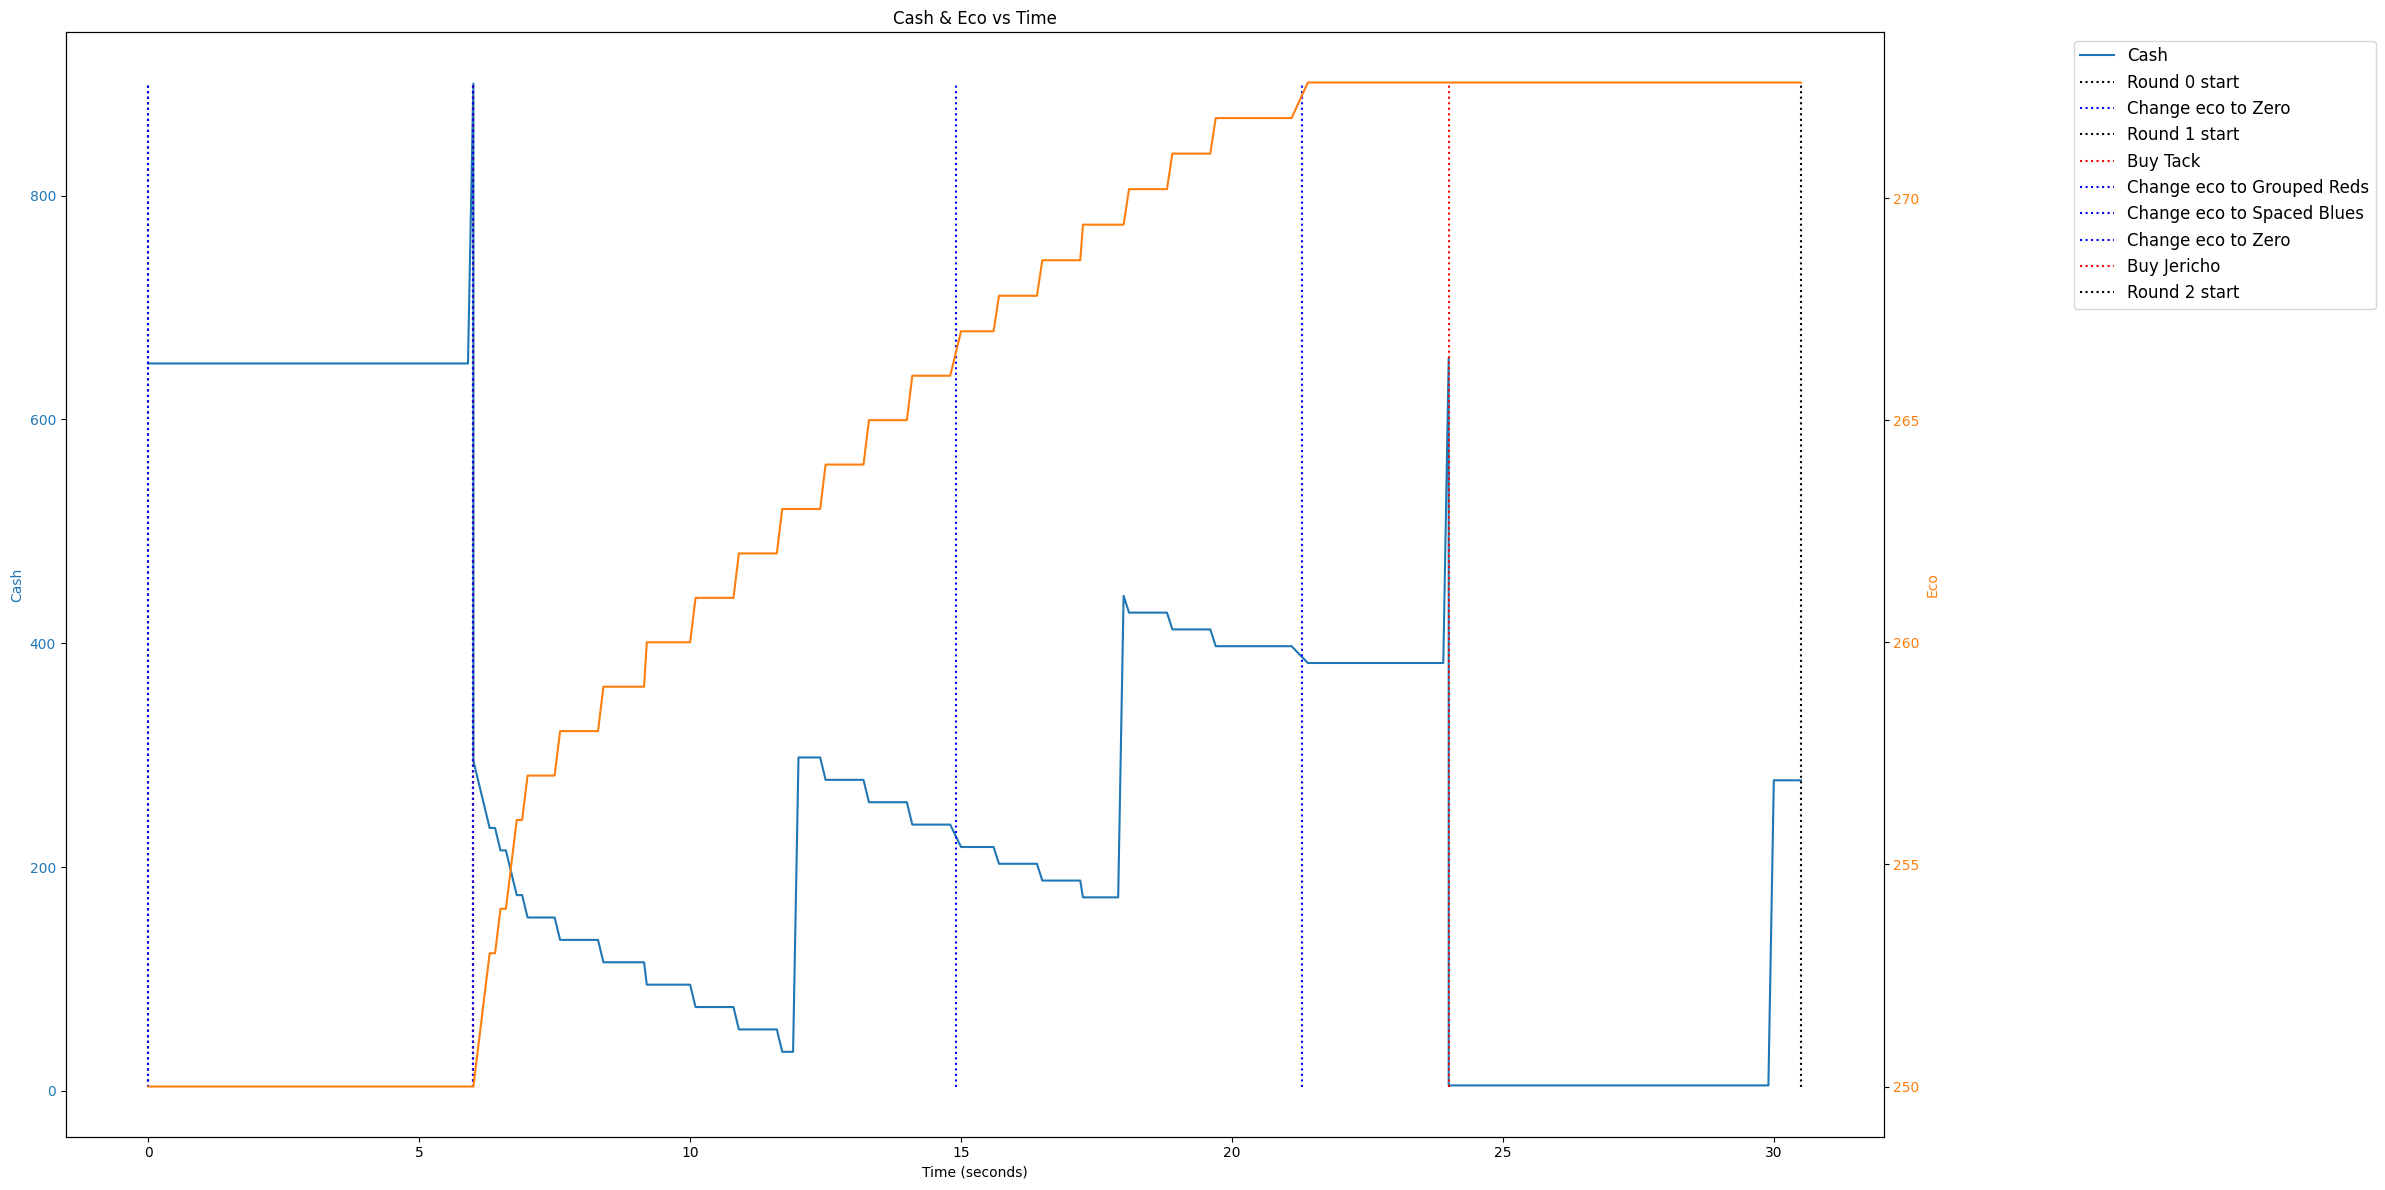

In [3]:
rounds = b2.Rounds(0.0)

buy_queue = [
    [b2.buyDefense(280 + 100 + 225, min_buy_time = rounds.getTimeFromRound(1), message = "Buy Tack")], #Buy 020 tack
    [b2.buyDefense(650, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_queue = [
        b2.ecoSend(time = rounds.getTimeFromRound(1), send_name = 'Grouped Reds', max_eco_amount = 267),
        b2.ecoSend(send_name = 'Spaced Blues', max_eco_amount = 272)
]

initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 0,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 2)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'eco_numbers_2')

## Standard Dartling Start with Jericho

It is reasonable to expect in most dartling alch farm games that the player will have access to 5 eco ticks, especially if the opponent is *also* playing Dartling.

,Time,Type,Message
0,0.0,Round,Round 0 start
1,0.0,Eco,Change eco to Zero
2,6.0,Round,Round 1 start
3,6.0,Eco,Change eco to Grouped Reds
4,12.0,Buy,Buy Dartling
5,18.1,Eco,Change eco to Spaced Blues
6,27.4,Eco,Change eco to Zero
7,30.0,Buy,Buy Jericho
8,32.3,Round,Round 2 start


The current cash and eco are (2.6000000000001364,277.0000000000001)


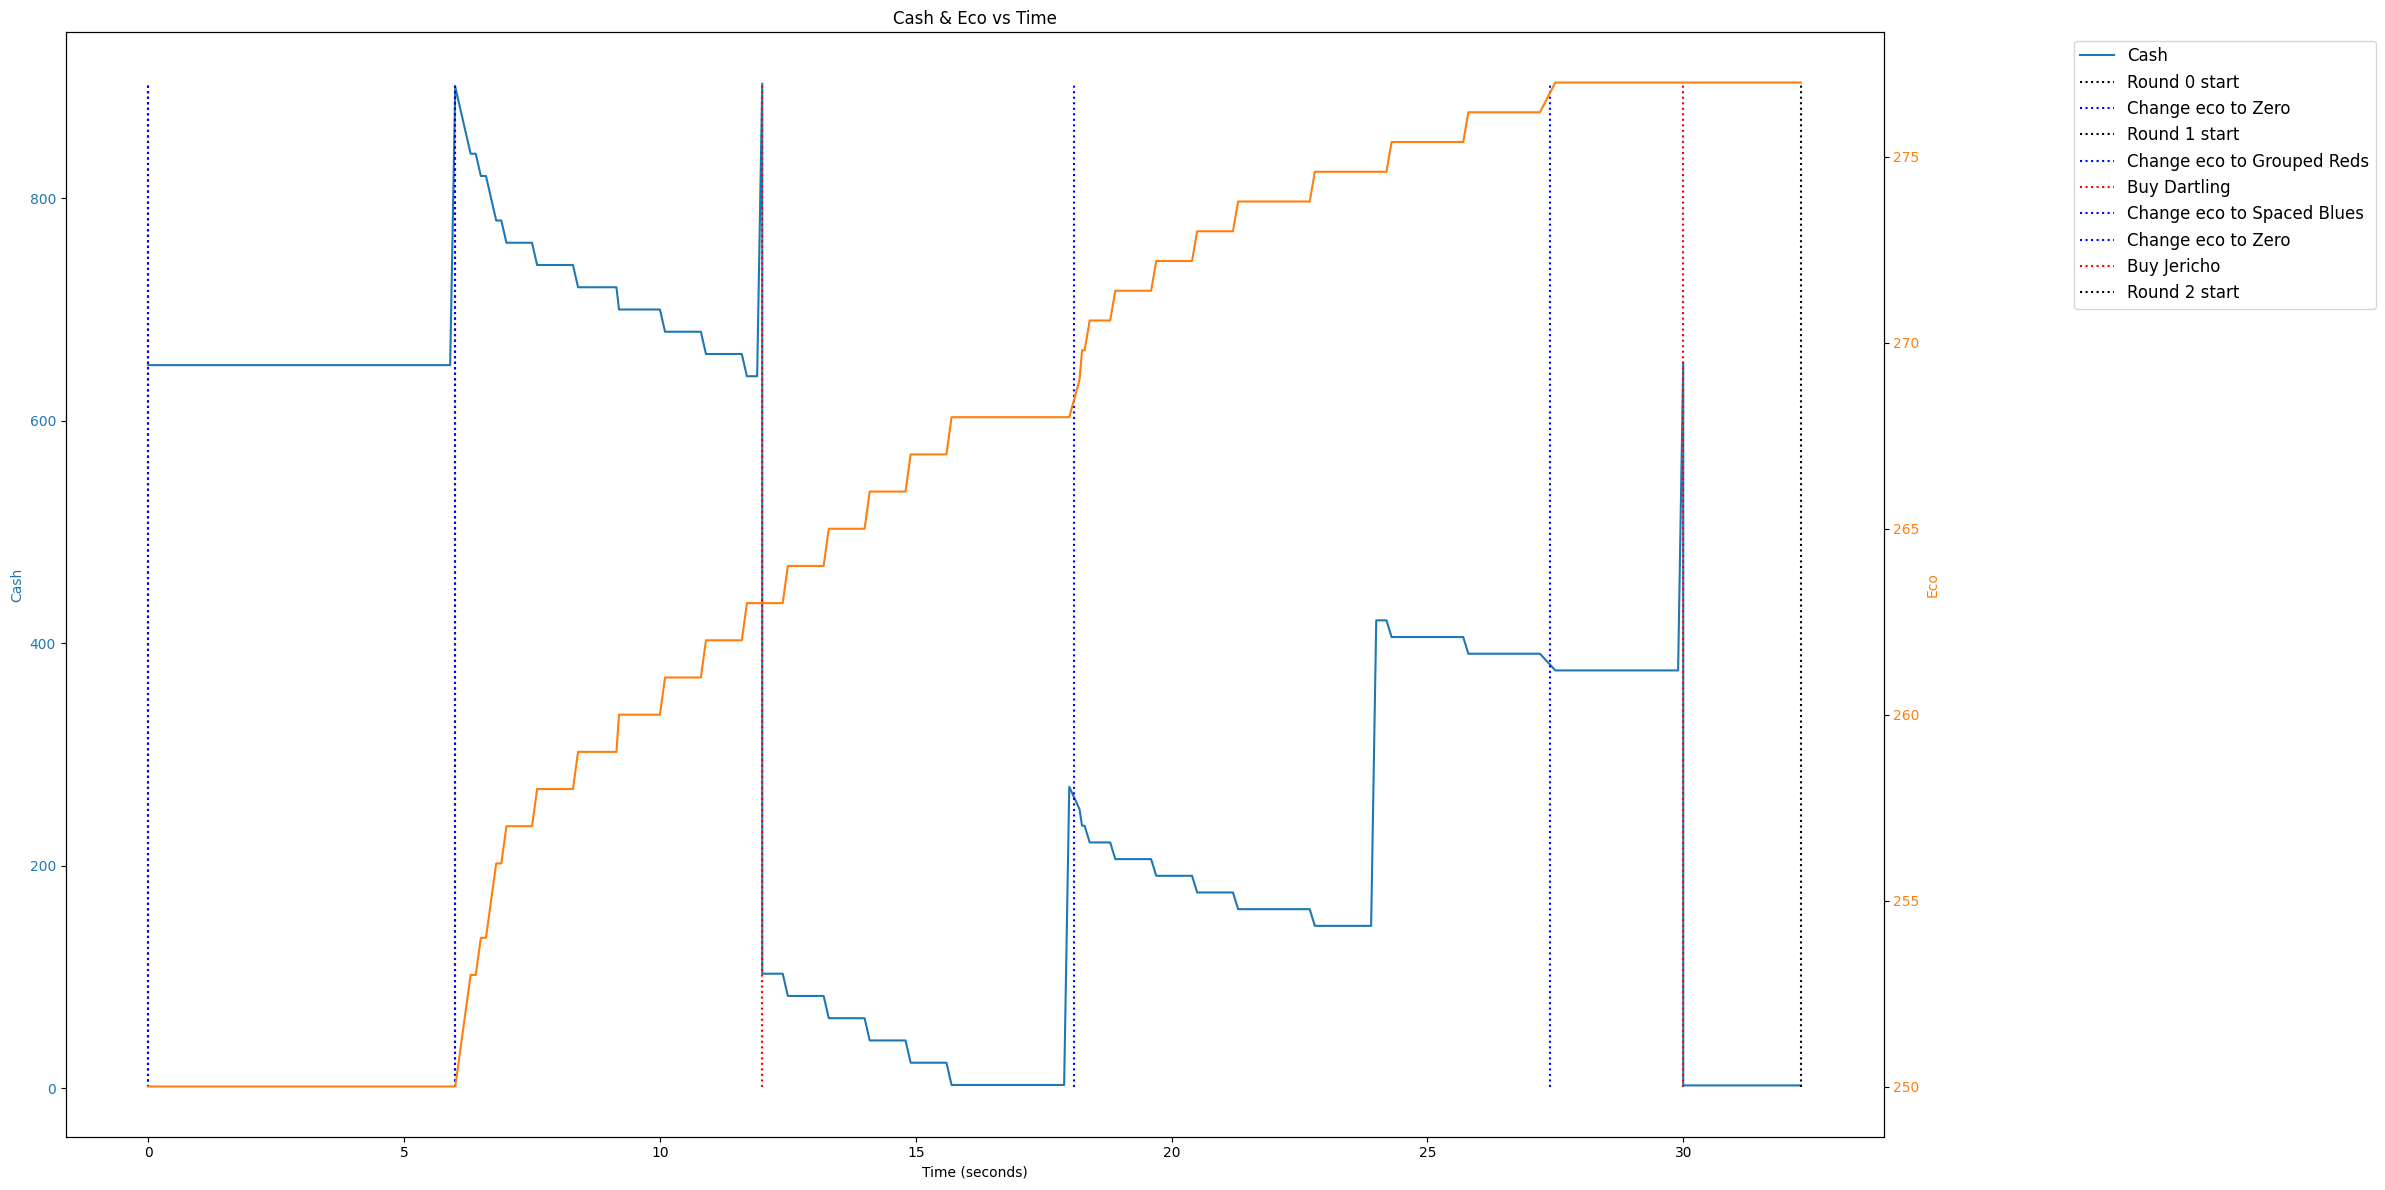

In [4]:
rounds = b2.Rounds(0.45)

buy_queue = [
    [b2.buyDefense(800, min_buy_time = rounds.getTimeFromRound(1.1), message = "Buy Dartling")], #Buy 000 dartling
    [b2.buyDefense(650, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_queue = [
        b2.ecoSend(time = rounds.getTimeFromRound(1), send_name = 'Grouped Reds', max_eco_amount = 269),
        b2.ecoSend(send_name = 'Spaced Blues', max_eco_amount = 277)
]

initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 0,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 2)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'eco_numbers_3')